# Topics: 
1. [Distortion.](#d)<br>
    a. [Finding Corners.](#c).<br>
    b. [Camera Calibration.](#cal).<br>
    c. [Recover distorted image.](#r)<br>
2. [Prespective Transform.](#p)
3. [Sobel operator.](#s)
4. [Color spaces.](#color)

<a id='d'></a>
# Distortion

>It is caused by the distortion from the camera's lens. The lens used in a camera is not a perfect piece of glass, so some form of distortion might be present in the image it captures. There is what we call **radial distortion** in which the light bends at a certain angle that deviates from a rectilinear plane.

There are three types of distortion: 
1. barrel.<br>
2. pincushion. <br>
3. waveform. <br>

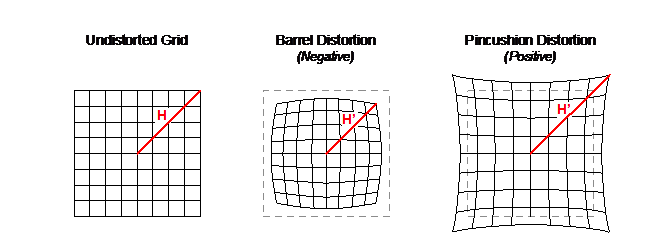


# Fixing Distortion:-
In order to fix distortion in cameras we need to callibrate this camera by finding corners in  some familiar images like chessboards and mapping each point in image to its corresponding point and calculate distortion of this camera.

In [1]:
import cv2 as cv
import numpy as np
from glob import glob

from matplotlib import pyplot as plt

IMAGES_PATH = "img"
CHESS_PATH = "chess images"

<a id='c'></a>
# Finding corners in chess board

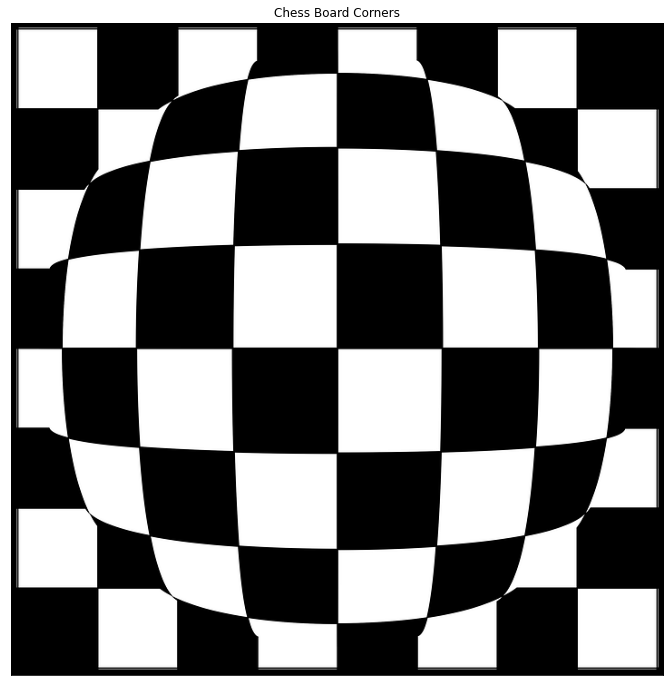

In [2]:
chess_board = cv.imread(IMAGES_PATH + '/chess_distorted.png')
plt.figure(figsize=(16, 12))
plt.imshow(chess_board)
plt.xticks([]);plt.yticks([])
plt.title("Chess Board Corners");

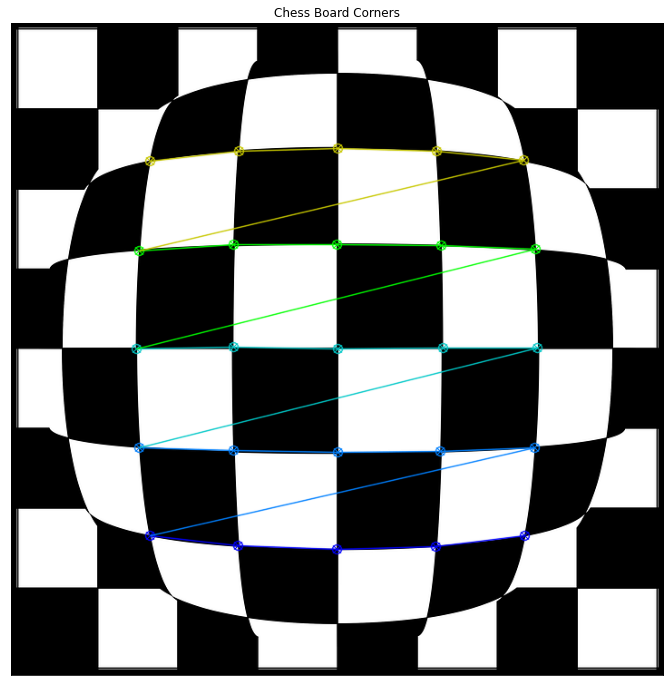

In [3]:
# extract corners from chess board image

# convert image to gray scale
gray = cv.cvtColor(chess_board, cv.COLOR_RGB2GRAY)
# find corners in chessboard
ret, corners = cv.findChessboardCorners(gray, (5, 5), None)

if ret: 
    cv.drawChessboardCorners(chess_board, (5, 5), corners, ret)
plt.figure(figsize=(16, 12))
plt.imshow(chess_board)
plt.xticks([]);plt.yticks([])
plt.title("Chess Board Corners");

<a id='cal'></a>
# Calculate Calibration matrix

In [4]:
images = glob('chess images/G*.jpg')

object_position = []
image_position = []

chess_board_position = np.zeros((8*6, 3))
chess_board_position[:, :2] = np.mgrid[:8, :6].T.reshape(-1, 2)

for image_path in images:
    img = cv.imread(image_path)
    gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)

    # Find the chessboard corners
    ret, corners = cv.findChessboardCorners(gray, (8,6), None)

    # If found, add object points, image points
    if ret == True:
        object_position.append(chess_board_position)
        image_position.append(corners)
        
# object_position = np.array([object_position]).reshape(-1, )
object_position = np.float32(object_position)
image_position = np.float32(image_position)
'''
mtx:  calibration matrix of camera.
dist: distortion matrix.
rvecs: rotation matrix.
tvec: translation matrix
'''
ret, mtx, dist, rvecs, tvecs = cv.calibrateCamera(object_position, image_position, 
                                                   (img.shape[1], img.shape[0]),None,None)

<a id='r'></a>
# Recover distorted images

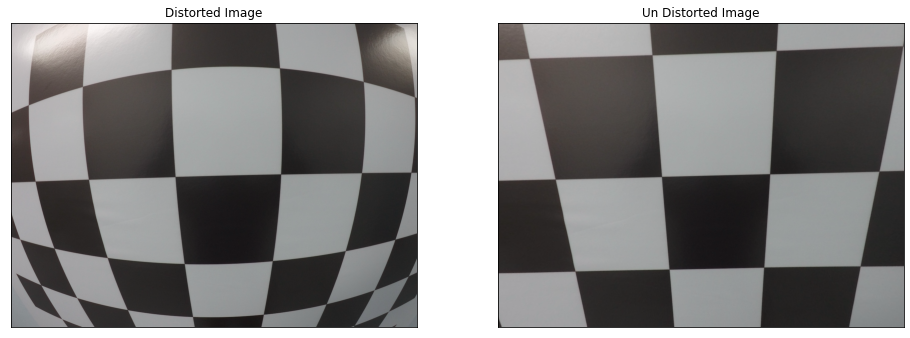

In [5]:
dist_image = cv.imread(CHESS_PATH + '/test_image.jpg')
undist_image = cv.undistort(dist_image, mtx, dist, None, mtx)

plt.figure(figsize=(16, 12))
plt.subplot(121)
plt.imshow(dist_image)
plt.xticks([]);plt.yticks([])
plt.title("Distorted Image")
plt.subplot(122)
plt.imshow(undist_image)
plt.xticks([]);plt.yticks([])
plt.title("Un Distorted Image");

<a id='p'></a>
# Prespective Transform

In order to get more accurate images, we sometimes need to transform prespective of image to another prospective (ex. bird's eye view) to : 
1. Know relation between lines (parallel, prependicular, other).
2. determine real size of objects and their depth form camera.

In order to preform this transformation we need to select `four points` from image and select their mappings in the other target image. 

For more details about prespective transformation and its implementaion check [this notebook](https://github.com/MahmoudEl-Husseni/Udacity-Introduction-to-Computer-Vision/blob/master/Udacity_Image%20processing_04.ipynb)

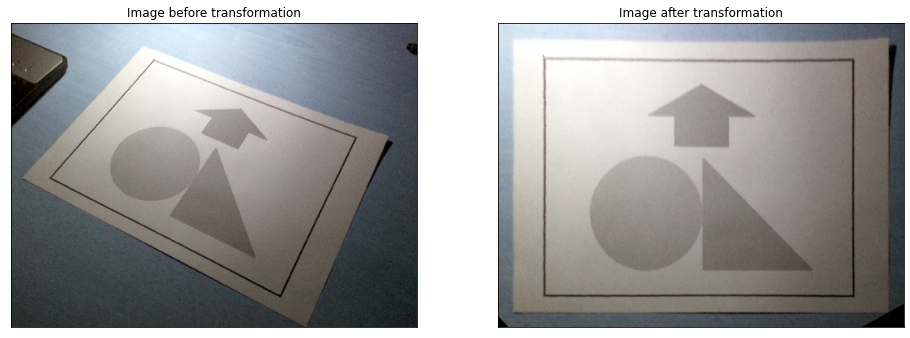

In [6]:
img = cv.imread(IMAGES_PATH + '/prespective_tramsform.jpg')

pts1 = np.float32([[164, 29], 
                   [464, 140], 
                   [15, 191],
                   [363, 373]])

pts2 = np.float32([[20, 20], 
                   [480, 20], 
                   [20, 355], 
                   [480, 355]])

M = cv.getPerspectiveTransform(pts1, pts2)

prespected_img = cv.warpPerspective(img, M, (500, 375))

plt.figure(figsize=(16, 12))
plt.subplot(121)
plt.imshow(img)
plt.xticks([]), plt.yticks([])
plt.title("Image before transformation")
plt.subplot(122)
plt.imshow(prespected_img)
plt.xticks([]), plt.yticks([])
plt.title("Image after transformation");

<a id='s'></a>
# Sobel Operator

Appling kernel to an image to detect change in intensities in image, we can consider this operation as gradient of image in direction which is determined according to the kernel selected.

Sobelx (gradient in x direction) kernel:

$$K_x = \begin{bmatrix}1 & 0 &  -1 \\ 1 & 0 & -1 \\ 1 & 0 & -1 \end{bmatrix}$$

Sobely (gradient in y direction) kernel:
$$K_y = \begin{bmatrix}1 & 1 &  1 \\ 0 & 0 & 0 \\ -1 & -1 & -1 \end{bmatrix}$$


In [7]:
def apply_kernel(img, kernel, thresh=0):
    h, w = img.shape
    hk, wk = kernel.shape
    out_image = np.zeros((h, w))
    start_idx_x, end_idx_x = hk // 2, h - hk//2
    start_idx_y, end_idx_y = wk // 2, w - wk//2

    for i in range(start_idx_x, end_idx_x):
        for j in range(start_idx_y, end_idx_y):
            out_image[i, j] = (img[i-hk//2:i+hk//2+1, j-wk//2:j+wk//2+1] * kernel).sum()
    
    out_image[out_image > thresh] = 0
    return out_image

def mag(x, y):
    out = np.sqrt(x**2 + y**2)
    return out
def angle(x, y):
    out = np.arctan2(y, x)
    return out
kernelx = np.float32([[1, 0, -1], 
                     [1, 0, -1], 
                     [1, 0, -1]])

kernely = np.float32([[1,1 , 1], 
                      [0, 0, 0], 
                      [-1, -1, -1]])

gray = cv.cvtColor(img, cv.COLOR_RGB2GRAY)
Sx = apply_kernel(gray, kernelx*3, thresh=100)
Sy = apply_kernel(gray, kernely*3, thresh=100)
mg = mag(Sx, Sy)
direction = angle(Sx, Sy)

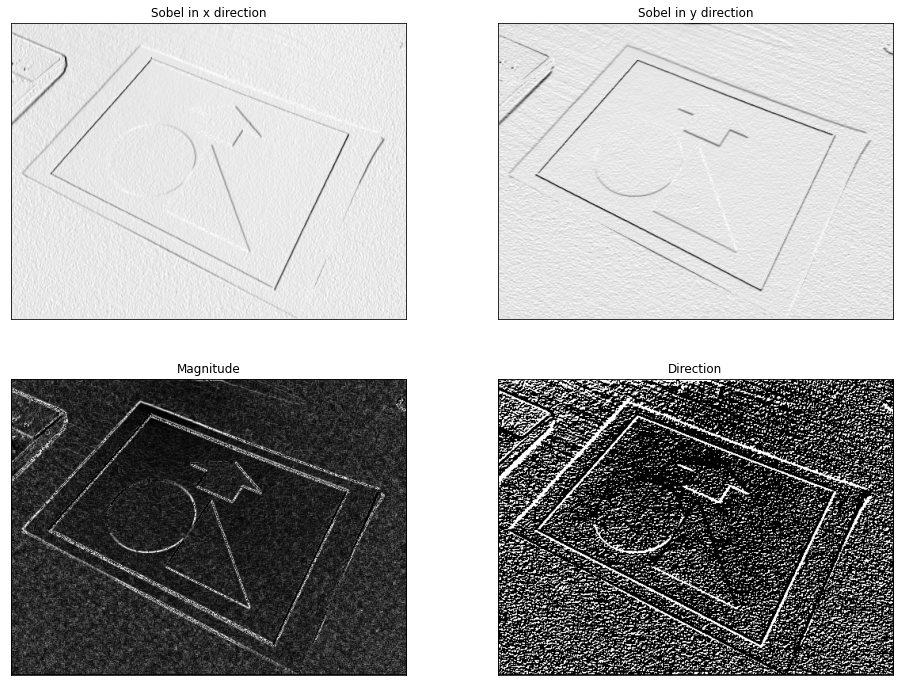

In [8]:
imgs = [Sx, Sy, mg.astype('uint8'), direction.astype('uint8')]
titles = ["Sobel in x direction", "Sobel in y direction", "Magnitude", "Direction"]
plt.figure(figsize=(16, 12))
for i, _img in enumerate(imgs):
    plt.subplot(2, 2, i+1)
    plt.imshow(_img, cmap='gray')
    plt.xticks([]);plt.yticks([])
    plt.title(titles[i])

<a id='color'></a>
# Color Spaces

We can represent image with different type of representations not only RGB each type of representation is called color space, 
much frequently used color spaces in computer vision: 
1. RGB : have three channels each channel represent instensity of its color (either Red, Green or Blue),
2. HSV (Hue, Saturation, value): hue represents main color in this pixel, saturation represents how much saturated is this pixel, value represents the value of color (0 means that there is no color).
3. HLS (Hue, Lightnes, Saturation): similiar to HSV except for Lightness reprsents lightness of pixel (255: white).

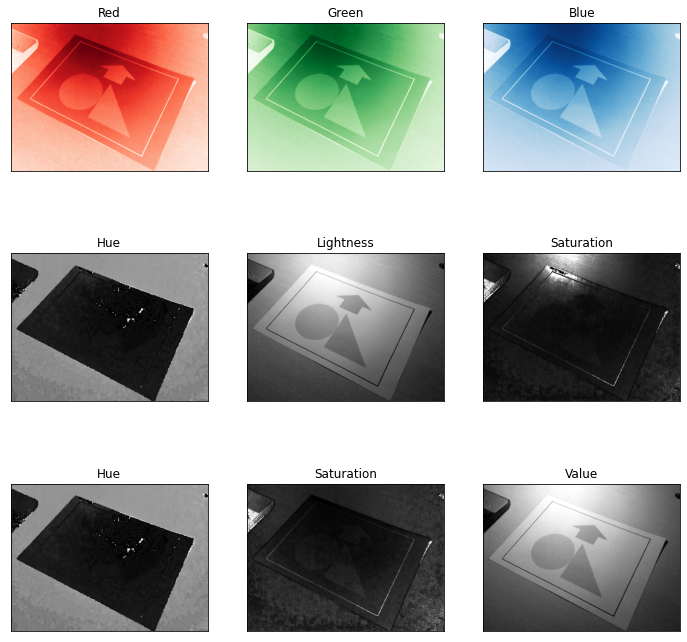

In [9]:
# R, G, B channels in image
R, G, B = [img[:, :, channel] for channel in range(3)]
rgbchannels = ['Red', 'Green', 'Blue']
hlschannels = ['Hue', 'Lightness', 'Saturation']
hsvchannels = ['Hue', 'Saturation', 'Value']

plt.figure(figsize=(12, 12))
for i in range(3):
    plt.subplot(3, 3, i+1)
    plt.imshow(img[:, :, i], cmap=rgbchannels[i]+'s')
    plt.xticks([]);plt.yticks([])
    plt.title(rgbchannels[i])
    
# H, L, S
hls = cv.cvtColor(img, cv.COLOR_RGB2HLS)
for i in range(3):
    plt.subplot(3, 3, i+4)
    plt.imshow(hls[:, :, i], cmap='gray')
    plt.xticks([]);plt.yticks([])
    plt.title(hlschannels[i])

# H, S, V
hsv = cv.cvtColor(img, cv.COLOR_RGB2HSV)
for i in range(3):
    plt.subplot(3, 3, i+7)
    plt.imshow(hsv[:, :, i], cmap='gray')
    plt.xticks([]);plt.yticks([])
    plt.title(hsvchannels[i])
